# Modules

In [48]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import numpy as np
import seaborn as sns

from scipy.stats import wilcoxon, pearsonr, spearmanr

from pdathome.constants import global_constants as gc, mappings as mp
from pdathome.evaluation import bland_altman_plot, calculate_pvalue, plot_significance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constants

In [49]:
d_plot_params = {
    'font.family': 'serif',
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 22,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 14,
    'legend.title_fontsize': 16,
}

sns.set(rc=d_plot_params)
sns.set_theme(style='ticks', rc=d_plot_params)

l_segment_cat = ['short', 'moderately_long', 'long', 'very_long']

# Load

In [50]:
import pickle

path_input = r'C:\Users\erik_\Documents\PhD\data\pdh_public\preprocessed_data\5.arm_swing_quantification'

with open(os.path.join(path_input, 'quantification.pickle'), 'rb') as f:
    d_quant = pickle.load(f)  

# Prepare data

In [51]:
d_quant_agg = {}
for subject in d_quant:
    d_quant_agg[subject] = {}
    for side in d_quant[subject]:
        d_quant_agg[subject][side] = {}
        for med_stage in d_quant[subject][side]:
            d_quant_agg[subject][side][med_stage] = {}
            for dataset in d_quant[subject][side][med_stage]:
                d_quant_agg[subject][side][med_stage][dataset] = {}
                for segment_length in d_quant[subject][side][med_stage][dataset]:
                    if 'range_of_motion' in d_quant[subject][side][med_stage][dataset][segment_length]:
                        rom = d_quant[subject][side][med_stage][dataset][segment_length]['range_of_motion']
                        pvel = np.concatenate([d_quant[subject][side][med_stage][dataset][segment_length]['forward_pav'], d_quant[subject][side][med_stage][dataset][segment_length]['backward_pav']])
                        d_quant_agg[subject][side][med_stage][dataset][segment_length] = {
                            'time_s': d_quant[subject][side][med_stage][dataset][segment_length]['time_s'],
                            'mrom': np.median(rom),
                            'prom': np.percentile(rom, 95),
                            'mvel': np.median(pvel),
                            'pvel': np.percentile(pvel, 95),
                        }

In [52]:
# l_measures = list(d_quant_agg['hbv002']['filtered_gait'][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'].keys())
l_measures = list(d_quant_agg['hbv002'][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['filtered']['overall'].keys())

l_dfs = []
for dataset in ['filtered', 'annotated']:
    df = pd.DataFrame()
    df['dataset'] = [dataset]*len(gc.participant_ids.PD_IDS)*4
    df['population'] = ['Pre-med MAS']*len(gc.participant_ids.PD_IDS) + ['Pre-med LAS']*len(gc.participant_ids.PD_IDS) + ['Post-med MAS']*len(gc.participant_ids.PD_IDS) + ['Post-med LAS']*len(gc.participant_ids.PD_IDS)
    df[gc.columns.ID] = gc.participant_ids.PD_IDS*4

    for measure in l_measures:
        l_pd_pre_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset]['overall'][measure] for x in gc.participant_ids.PD_IDS]
        l_pd_pre_las = [d_quant_agg[x][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset]['overall'][measure] for x in gc.participant_ids.PD_IDS]
        l_pd_post_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset]['overall'][measure] for x in gc.participant_ids.PD_IDS]
        l_pd_post_las = [d_quant_agg[x][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset]['overall'][measure] for x in gc.participant_ids.PD_IDS]

        df = pd.concat([df, pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las], index=[measure]).T], axis=1)

    l_dfs.append(df)

df = pd.concat(l_dfs, axis=0)

In [53]:
min_seconds = 60

l_valid_pd_ids = [x for x in gc.participant_ids.PD_IDS if d_quant[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['filtered']['overall']['time_s'] >= min_seconds and d_quant[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['filtered']['overall']['time_s'] >= min_seconds]
l_valid_hc_ids = [x for x in gc.participant_ids.HC_IDS if d_quant[x][gc.descriptives.MOST_AFFECTED_SIDE]['HC']['filtered']['overall']['time_s'] >= min_seconds]

df_valid = df.loc[df[gc.columns.ID].isin(l_valid_pd_ids)]

# Inspect

In [55]:
print(f"Number of subjects: {len(d_quant_agg.keys())}")
print(f"Number of PD subjects: {len([x for x in gc.participant_ids.PD_IDS if x in d_quant_agg.keys()])}")
print(f"Number of HC subjects: {len([x for x in gc.participant_ids.HC_IDS if x in d_quant_agg.keys()])}")
print(f"Number of valid PD subjects: {len(l_valid_pd_ids)}")
print(f"Number of valid HC subjects: {len(l_valid_hc_ids)}")

Number of subjects: 44
Number of PD subjects: 21
Number of HC subjects: 23
Number of valid PD subjects: 18
Number of valid HC subjects: 23


#### Amount of data per subject

In [56]:
print("Predicted gait - Minutes of data")

print("\npre-medication")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['unfiltered']['overall']['time_s']/60 for x in l_valid_pd_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

print("\npost-medication")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['unfiltered']['overall']['time_s']/60 for x in l_valid_pd_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

print(f"\ncontrols")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS]['unfiltered']['overall']['time_s']/60 for x in l_valid_hc_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

Predicted gait - Minutes of data

pre-medication
Mean (SD): 17.92 (7.09)
Min-Max: 8.46 - 31.88

post-medication
Mean (SD): 17.08 (7.26)
Min-Max: 4.81 - 31.98

controls
Mean (SD): 34.37 (10.37)
Min-Max: 18.41 - 58.77


In [57]:
print("Predicted gait - Minutes of data")

print("\npre-medication")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['filtered']['overall']['time_s']/60 for x in l_valid_pd_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

print("\npost-medication")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED]['filtered']['overall']['time_s']/60 for x in l_valid_pd_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

print(f"\ncontrols")
time_minutes = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS]['filtered']['overall']['time_s']/60 for x in l_valid_hc_ids]
print(f"Mean (SD): {np.round(np.mean(time_minutes),2)} ({np.round(np.std(time_minutes),2)})")
print(f"Min-Max: {np.round(np.min(time_minutes),2)} - {np.round(np.max(time_minutes),2)}")

Predicted gait - Minutes of data

pre-medication
Mean (SD): 7.71 (5.67)
Min-Max: 1.17 - 20.76

post-medication
Mean (SD): 7.7 (5.04)
Min-Max: 1.45 - 19.05

controls
Mean (SD): 14.07 (5.73)
Min-Max: 2.28 - 26.5


In [58]:
l_counts = [y for z in [list(d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED]['filtered'].keys()) for x in l_valid_pd_ids] for y in z if y != 'overall']

print("Filtered gait - Number of participants stratified by sequence duration\n")

for seq_dur in mp.segment_map.values():
    print(f"{seq_dur}: {l_counts.count(seq_dur)} / {len(l_valid_pd_ids)}")  

Filtered gait - Number of participants stratified by sequence duration

non_gait: 0 / 18
short: 13 / 18
moderately_long: 18 / 18
long: 17 / 18
very_long: 17 / 18


# Plot data

#### Impact of misclassifications

In [61]:
# Flatten the dictionary
rows = []
for subject_id in l_valid_pd_ids:
    for affected_side in d_quant_agg[subject_id]:
        for med_stage in d_quant_agg[subject_id][affected_side]:
            for dataset in d_quant_agg[subject_id][affected_side][med_stage]:
                for segment_length in ['overall']:# d_quant_agg[subject_id][affected_side][med_stage][dataset]:
                    row = {
                        "id": subject_id,
                        "population": f'{med_stage} {affected_side}',
                        "dataset": dataset,
                    }
                    metrics = d_quant_agg[subject_id][affected_side][med_stage][dataset][segment_length]
                    row.update(metrics)  # Add metrics (mrom, prom, mvel, pvel)
                    rows.append(row)

# Create the DataFrame
df_quant = pd.DataFrame(rows)

C:\Users\erik_\Documents\PhD\code\pdathome\src\pdathome\evaluation.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_values = df1[df1[hue].eq(df2[hue])][hue].unique()


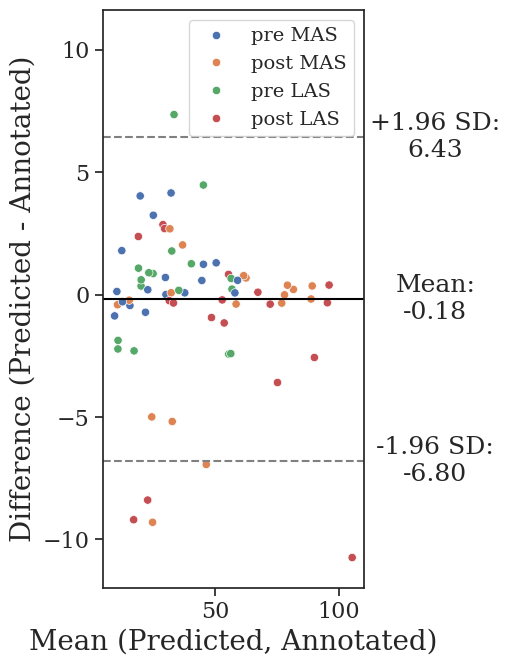

In [62]:
measure = 'prom'

fig, ax = plt.subplots(figsize=(6,7))

ax, colors = bland_altman_plot(df_quant.loc[df_quant['dataset']=='filtered'], df_quant.loc[df_quant['dataset']=='annotated'], x=measure, hue='population', axs=ax, legend=True, ax=ax, x_loc_mult_factor=1.35)

ax.legend(loc='upper right')

ax.set_xlabel('Mean (Predicted, Annotated)')
ax.set_ylabel('Difference (Predicted - Annotated)')

fig.tight_layout()

plt.show()

C:\Users\erik_\Documents\PhD\code\pdathome\src\pdathome\evaluation.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_values = df1[df1[hue].eq(df2[hue])][hue].unique()
C:\Users\erik_\Documents\PhD\code\pdathome\src\pdathome\evaluation.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_values = df1[df1[hue].eq(df2[hue])][hue].unique()
C:\Users\erik_\Documents\PhD\code\pdathome\src\pdathome\evaluation.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_values = df1[df1[hue].eq(df2[hue])][hue].unique()
C:\Users\erik_\Documents\PhD\code\pdathome\src\pdathome\evaluation.py:119: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  common_values = df1[df1[hue].eq(df2[hue])][hue].unique()


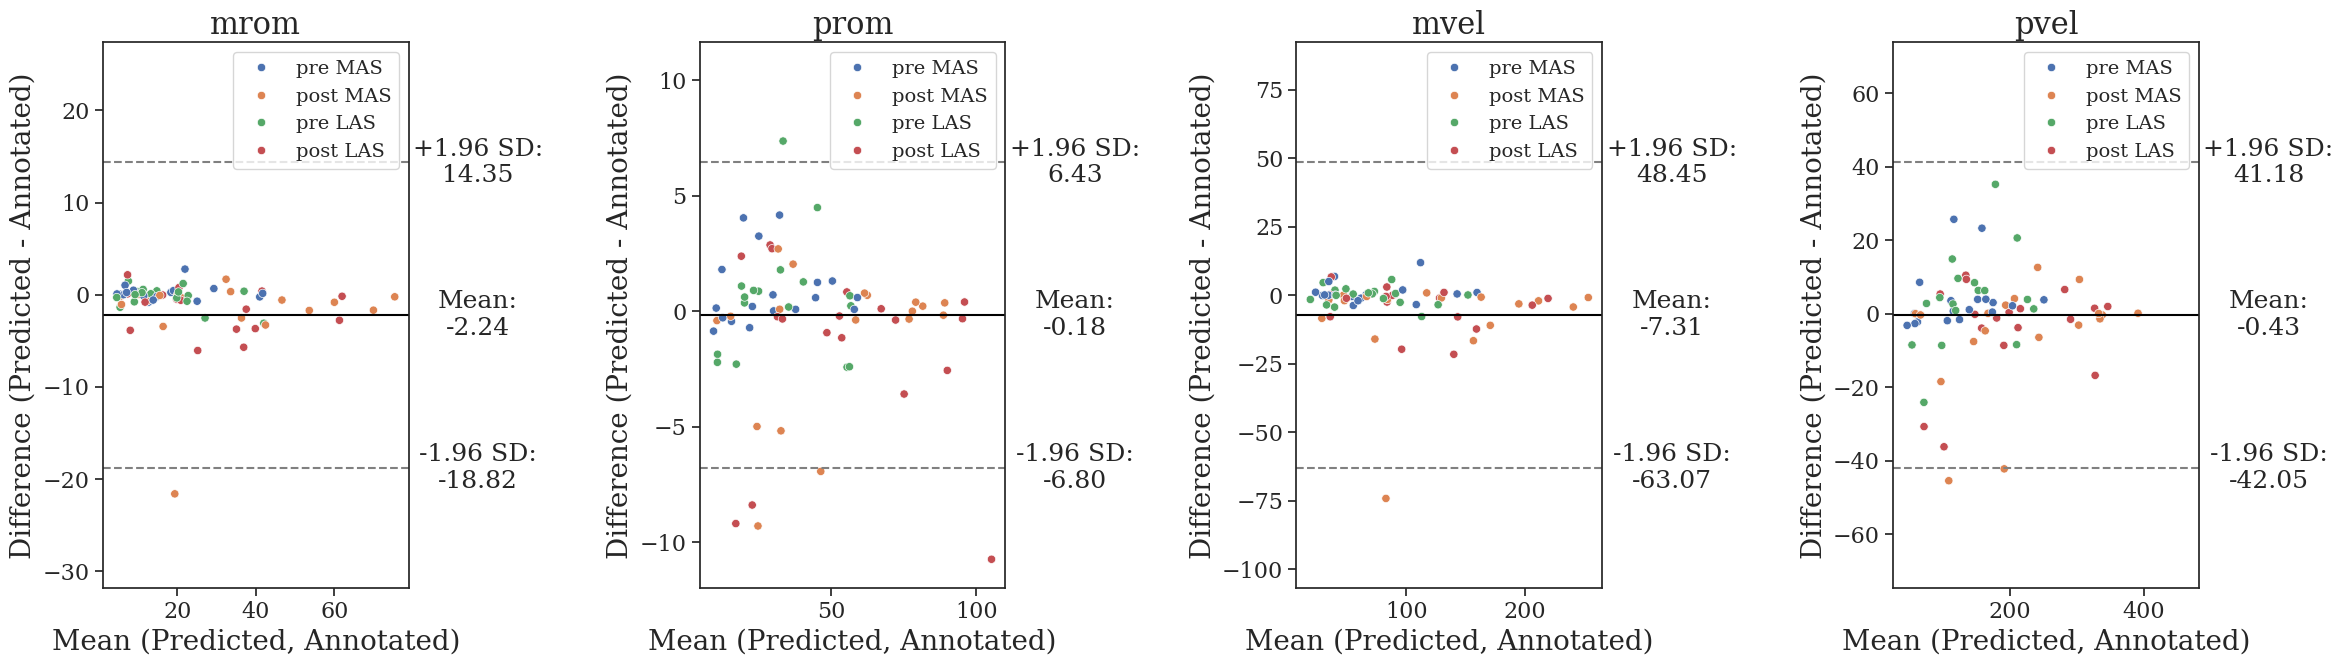

In [63]:
l_measures = ['mrom', 'prom', 'mvel', 'pvel']

fig, ax = plt.subplots(ncols=4, figsize=(24,7))

for j, measure in enumerate(l_measures):
    ax[j], colors = bland_altman_plot(df_quant.loc[df_quant['dataset']=='filtered'], df_quant.loc[df_quant['dataset']=='annotated'], x=measure, hue='population', axs=ax[j], legend=True, ax=ax[j], x_loc_mult_factor=1.3)

    ax[j].legend(loc='upper right')

    ax[j].set_title(measure)
    ax[j].set_xlabel('Mean (Predicted, Annotated)')
    ax[j].set_ylabel('Difference (Predicted - Annotated)')

fig.tight_layout()

plt.show()

In [64]:
measure = 'prom'
l_populations = ['PD pre-med MAS', 'PD pre-med LAS', 'PD post-med MAS', 'PD post-med LAS']

l_icc = []
l_pvalue = []
l_ci = []

icc_type = 'ICC1'
df_icc_new = df_quant.loc[df_quant['dataset'].isin(['filtered', 'annotated'])]

for population in df_icc_new['population'].unique():
    icc = pg.intraclass_corr(data=df_icc_new.loc[df_icc_new['population']==population], targets=gc.columns.ID, raters='dataset', ratings=measure)

    l_icc.append(icc.loc[icc['Type']==icc_type, 'ICC'].values[0])
    l_pvalue.append(icc.loc[icc['Type']==icc_type, 'pval'].values[0])
    l_ci.append(icc.loc[icc['Type']==icc_type, 'CI95%'].values[0])

pd.DataFrame([l_populations, l_icc, l_pvalue, l_ci], index=['Population', 'ICC', 'p-value', 'CI95%']).T    

,Population,ICC,p-value,CI95%
0,PD pre-med MAS,0.994344,0.0,"[0.99, 1.0]"
1,PD pre-med LAS,0.992106,0.0,"[0.98, 1.0]"
2,PD post-med MAS,0.972419,0.0,"[0.93, 0.99]"
3,PD post-med LAS,0.989536,0.0,"[0.97, 1.0]"


#### Sensitivity of arm swing parameters

Population differences

PD pre-med vs PD post-med p-value:  0.000579833984375
PD post-med vs controls p-value:  0.45787390413750895
PD pre-med vs controls p-value:  0.0002877278086290374


C:\Users\erik_\AppData\Local\Temp\ipykernel_10604\3104993571.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])


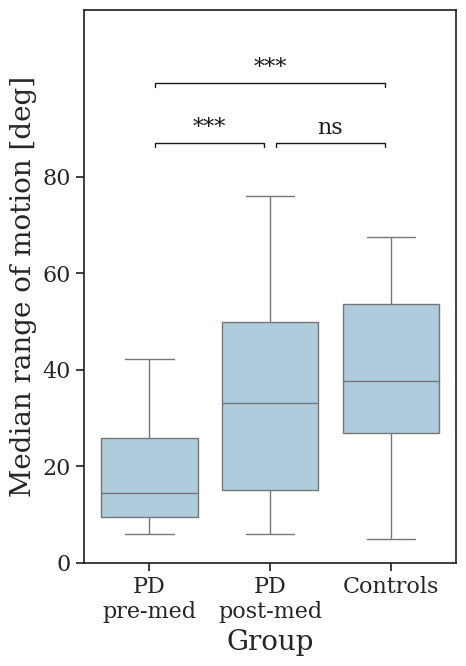

In [65]:
measure = 'mrom'
dataset = 'filtered'
segment_duration = 'very_long'

l_pd_ids_segments = [x for x in l_valid_pd_ids if segment_duration in d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset].keys() and segment_duration in d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset].keys()]
l_hc_ids_segments = [x for x in l_valid_hc_ids if segment_duration in d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS][dataset].keys()]

l_pd_pre_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset][segment_duration][measure] for x in l_pd_ids_segments]
l_pd_post_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset][segment_duration][measure] for x in l_pd_ids_segments]
l_hc_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS][dataset][segment_duration][measure] for x in l_hc_ids_segments]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_post_mas + l_hc_mas], index=[measure]).T
df_group['group'] = ['PD pre-med']*len(l_pd_pre_mas) + ['PD post-med']*len(l_pd_post_mas) + ['HC']*len(l_hc_mas)

fig, ax = plt.subplots(figsize=(5,7))

sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]

y_min_significance = ymax * 1.05 
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_post_mas, test='wilcoxon')[1]
print("PD pre-med vs PD post-med p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_hc_mas, test='ranksums')[1]
print("PD post-med vs controls p-value: ", p_value)

plot_significance(ax=ax, x_min=1.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_pd_pre_mas, l_hc_mas, test='ranksums')[1]
print("PD pre-med vs controls p-value: ", p_value)

y_min_significance = ymax * 1.2

plot_significance(ax=ax, x_min=0.05,
                  x_max=1.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
ax.set_yticks(ax.get_yticks()[:-2])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

ax.set_ylabel('Median range of motion [deg]')
ax.set_xlabel('Group')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

In [66]:
np.mean(d_quant['hbv002']['MAS']['pre']['filtered']['overall']['range_of_motion'])

17.69157675123674

In [68]:
# measure = 'mrom'
measure = 'range_of_motion'
dataset = 'filtered'
segment_duration = 'overall'
affected_side = gc.descriptives.LEAST_AFFECTED_SIDE

l_pd_ids_segments = [x for x in l_valid_pd_ids if segment_duration in d_quant[x][affected_side][gc.descriptives.PRE_MED][dataset].keys() and segment_duration in d_quant[x][affected_side][gc.descriptives.POST_MED][dataset].keys()]
l_hc_ids_segments = [x for x in l_valid_hc_ids if segment_duration in d_quant[x][affected_side][gc.descriptives.CONTROLS][dataset].keys()]

l_pd_pre_mas = [np.mean(d_quant[x][affected_side][gc.descriptives.PRE_MED][dataset][segment_duration][measure]) for x in l_pd_ids_segments]
l_pd_post_mas = [np.mean(d_quant[x][affected_side][gc.descriptives.POST_MED][dataset][segment_duration][measure]) for x in l_pd_ids_segments]

print(f'Mean (SD) pre: {np.round(np.mean(l_pd_pre_mas), 2)} ({np.round(np.std(l_pd_pre_mas), 2)})')
print(f'Mean (SD) post: {np.round(np.mean(l_pd_post_mas), 2)} ({np.round(np.std(l_pd_post_mas), 2)})')

Mean (SD) pre: 17.83 (8.98)
Mean (SD) post: 28.44 (15.18)


PD pre-med MAS vs PD pre-med LAS p-value:  0.44229888916015625
PD post-med MAS vs PD post-med LAS p-value:  0.28372955322265625
Controls MAS vs controls LAS p-value:  0.5803380012512207


C:\Users\erik_\AppData\Local\Temp\ipykernel_10604\3363078030.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS',


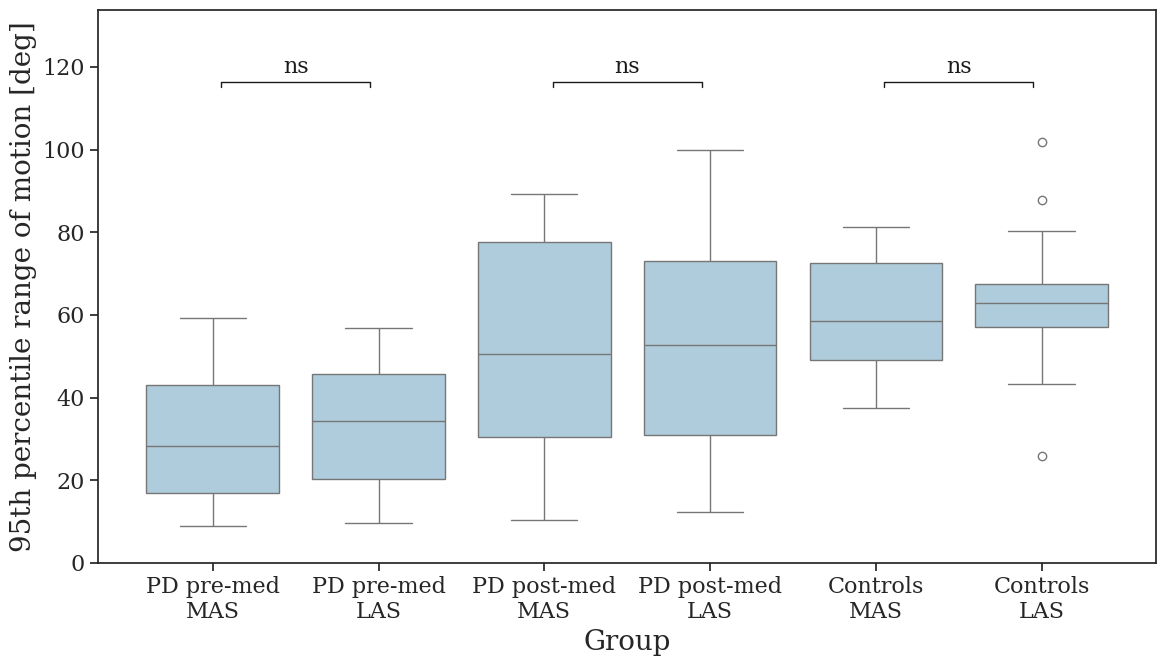

In [69]:
dataset = 'filtered'
measure = 'prom'
segment_length = 'overall'

l_pd_pre_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset][segment_length][measure] for x in l_valid_pd_ids]
l_pd_pre_las = [d_quant_agg[x][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.PRE_MED][dataset][segment_length][measure] for x in l_valid_pd_ids]
l_pd_post_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset][segment_length][measure] for x in l_valid_pd_ids]
l_pd_post_las = [d_quant_agg[x][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.POST_MED][dataset][segment_length][measure] for x in l_valid_pd_ids]
l_hc_mas = [d_quant_agg[x][gc.descriptives.MOST_AFFECTED_SIDE][gc.descriptives.CONTROLS][dataset][segment_length][measure] for x in l_valid_hc_ids]
l_hc_las = [d_quant_agg[x][gc.descriptives.LEAST_AFFECTED_SIDE][gc.descriptives.CONTROLS][dataset][segment_length][measure] for x in l_valid_hc_ids]

df_group = pd.DataFrame([l_pd_pre_mas + l_pd_pre_las + l_pd_post_mas + l_pd_post_las + l_hc_mas + l_hc_las], index=[measure]).T
df_group['group'] = ['PD pre-med MAS']*len(l_pd_pre_mas) + ['PD pre-med LAS']*len(l_pd_pre_las) + ['PD post-med MAS']*len(l_pd_post_mas) + ['PD post-med LAS']*len(l_pd_post_las) + ['HC MAS']*len(l_hc_mas) + ['HC LAS']*len(l_hc_las)

fig, ax = plt.subplots(figsize=(12,7))

sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax)

ymax = ax.get_ylim()[1]

y_min_significance = ymax * 1.05
gap = y_min_significance * 1.05 - ymax

p_value = calculate_pvalue(l_pd_pre_mas, l_pd_pre_las, test='wilcoxon')[1]
print("PD pre-med MAS vs PD pre-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=0.05,
                  x_max=0.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

p_value = calculate_pvalue(l_pd_post_mas, l_pd_post_las, test='wilcoxon')[1]
print("PD post-med MAS vs PD post-med LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=2.05,
                  x_max=2.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 
         
p_value = calculate_pvalue(l_hc_mas, l_hc_las, test='wilcoxon')[1]
print("Controls MAS vs controls LAS p-value: ", p_value)

plot_significance(ax=ax, x_min=4.05,
                  x_max=4.95, pvalue=p_value,
                  y_min_significance=y_min_significance, gap=gap, row=1, 
                  text_size=16) 

ax.set_ylim(0, 1.1*ax.get_ylim()[1])
# ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
ax.set_xticklabels(['PD pre-med\nMAS', 'PD pre-med\nLAS', 'PD post-med\nMAS', 
                    'PD post-med\nLAS', 'Controls\nMAS', 'Controls\nLAS'])

# ax.set_ylabel('Peak velocity [deg/s]')
ax.set_ylabel('95th percentile range of motion [deg]')
ax.set_xlabel('Group')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

KeyError: 'filtered_gait'

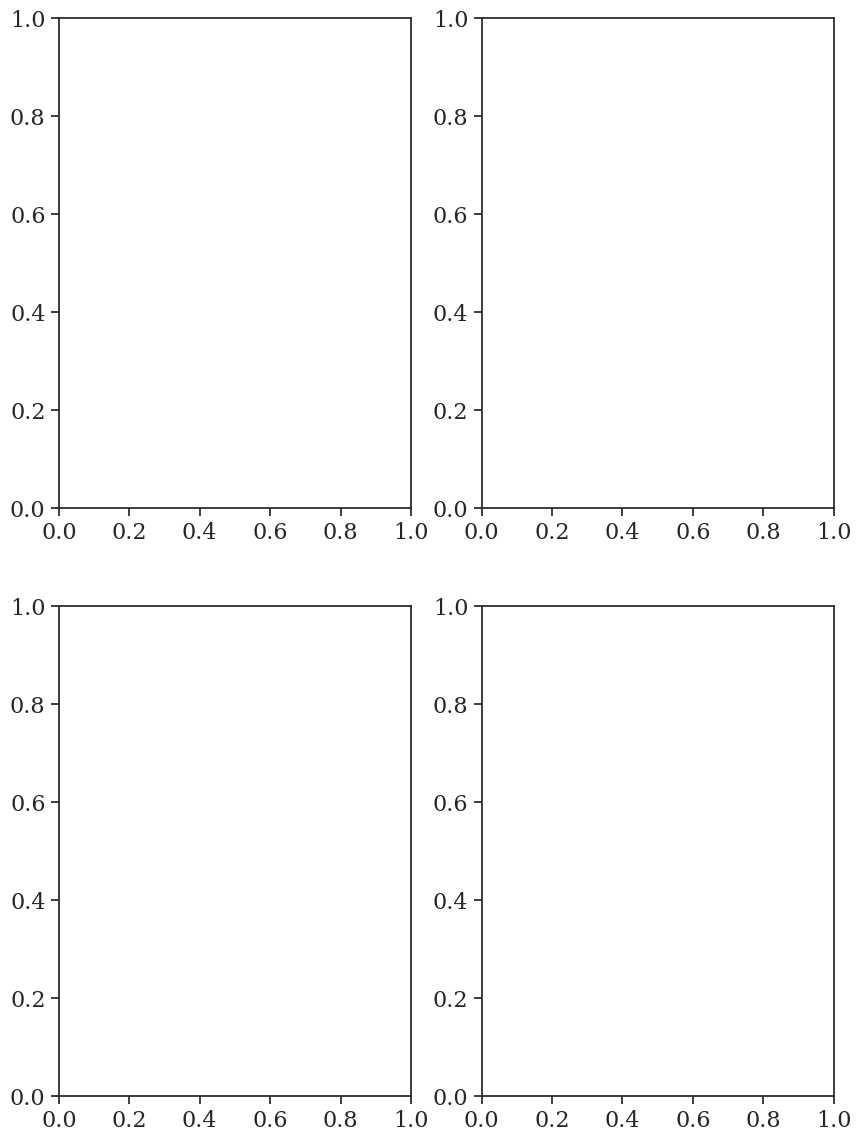

In [70]:
dataset = 'filtered_gait'
measure = 'range_of_motion_median'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,14))

for i, segment_duration in enumerate(l_segment_cat):

    l_pd_ids_segment = [x for x in l_valid_pd_ids if segment_duration in d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys() and segment_duration in d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys()]
    l_hc_ids_segment = [x for x in l_valid_hc_ids if segment_duration in d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure].keys()]

    l_pd_ids_segment_pre = [d_quant[x][dataset][gc.descriptives.PRE_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segment]
    l_pd_ids_segment_post = [d_quant[x][dataset][gc.descriptives.POST_MED][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_pd_ids_segment]
    l_hc_ids_segment = [d_quant[x][dataset]['HC'][gc.descriptives.MOST_AFFECTED_SIDE]['values'][measure][segment_duration] for x in l_hc_ids_segment]

    df_group = pd.DataFrame([l_pd_ids_segment_pre + l_pd_ids_segment_post + l_hc_ids_segment], index=[measure]).T
    df_group['group'] = ['PD pre-med']*len(l_pd_ids_segment_pre) + ['PD post-med']*len(l_pd_ids_segment_post) + ['HC']*len(l_hc_ids_segment)

    sns.boxplot(x='group', y=measure, data=df_group, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR, ax=ax[i//2,i%2])

    ymax = ax[i//2,i%2].get_ylim()[1]

    y_min_significance = ymax * 1.05
    gap = y_min_significance * 1.05 - ymax

    p_value = calculate_pvalue(l_pd_ids_segment_pre, l_pd_ids_segment_post, test='wilcoxon')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                    x_max=0.95, pvalue=p_value,
                    y_min_significance=y_min_significance, gap=gap, row=1, 
                    text_size=16) 
    
    p_value = calculate_pvalue(l_pd_ids_segment_post, l_hc_ids_segment, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=1.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 
    
    y_min_significance = ymax * 1.2
    
    p_value = calculate_pvalue(l_pd_ids_segment_pre, l_hc_ids_segment, test='ranksums')[1]

    plot_significance(ax=ax[i//2,i%2], x_min=0.05,
                      x_max=1.95, pvalue=p_value,
                      y_min_significance=y_min_significance, gap=gap, row=1, 
                      text_size=16) 

    ax[i//2,i%2].set_title(f"{mp.segment_rename[segment_duration]}")
    ax[i//2,i%2].set_ylim(0, 1.1*ax[i//2,i%2].get_ylim()[1])
    # ax.set_xticklabels([d_pop_rename[x] for x in l_order_populations])
    ax[i//2,i%2].set_xticklabels(['PD\npre-med', 'PD\npost-med', 'Controls'])

    ax[i//2,i%2].set_ylabel(mp.arm_swing_parameter_map[measure])
    ax[i//2,i%2].set_xlabel('Population')

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_population.png'))

plt.show()

In [71]:
d_filtering_gait_performance = {}
for subject in gc.participant_ids.PD_IDS:
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', 'arm_activity', f'{subject}.json'), 'r') as f:
        d_filtering_gait_performance[subject] = json.load(f)

for subject in gc.participant_ids.PD_IDS:
    d_quant_agg[subject]['clinical'] = d_filtering_gait_performance[subject]['clinical']

df_filtered = df_valid.loc[df_valid['dataset']=='filtered'].copy()

for subject in gc.participant_ids.PD_IDS:
    for med_stage in ['pre', 'post']:
        for affected_side in ['MAS', 'LAS']:
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage.capitalize()}-med {affected_side}'), 'subscore'] = d_quant_agg[subject]['clinical']['updrs'][med_stage][affected_side]['subscore']
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage.capitalize()}-med {affected_side}'), 'total_score'] = d_quant_agg[subject]['clinical']['updrs'][med_stage][affected_side]['total']


In [73]:
df_filtered.head()

,dataset,population,id,time_s,mrom,prom,mvel,pvel,subscore,total_score
0,filtered,Pre-med MAS,hbv002,632.25,18.459339,30.042216,66.655722,115.164646,8.0,11.0
1,filtered,Pre-med MAS,hbv012,217.69,19.223556,34.177204,91.009900,169.434684,10.0,18.0
2,filtered,Pre-med MAS,hbv014,631.75,12.209798,21.406899,53.737624,123.447759,12.0,14.0
3,filtered,Pre-med MAS,hbv015,84.49,9.049490,26.560111,43.205582,128.603714,17.0,24.0
4,filtered,Pre-med MAS,hbv016,136.86,5.362421,10.285293,29.589349,56.886862,8.0,10.0


prom 
Correlation: -0.316 [-0.68222629  0.17698913]
P-value: 0.2014


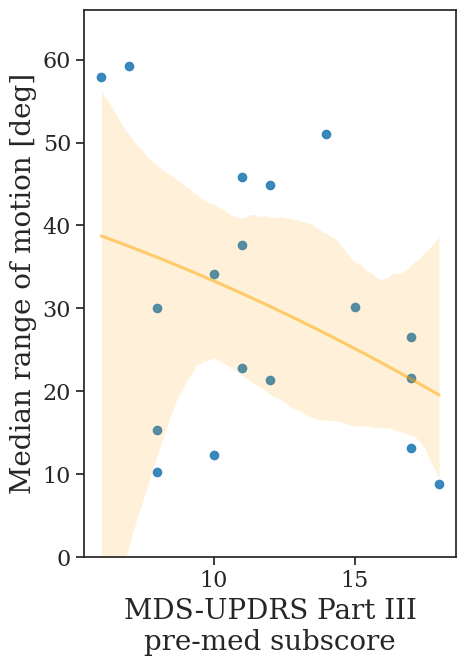

In [78]:
measure = 'prom'
correlation_metric = 'spearman'

df_med = df_filtered.loc[df_filtered['population']=='Pre-med MAS']

fig, ax = plt.subplots(figsize=(5,7))

sns.scatterplot(data=df_med, x='subscore', y=measure, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)
sns.regplot(x='subscore', y=measure, data=df_med, order=2,
            scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR}, ci=95,
            line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax)

if correlation_metric == 'pearson':
    rho = np.round(pearsonr(df_med[measure], df_med['subscore']).statistic,4)
    p_value = np.round(pearsonr(df_med[measure], df_med['subscore']).pvalue,4)
else:
    rho = np.round(spearmanr(df_med[measure], df_med['subscore']).correlation,4)
    p_value = np.round(spearmanr(df_med[measure], df_med['subscore']).pvalue,4)

zr = np.log((1+rho)/(1-rho))/2
lower = zr - 1.96/np.sqrt(len(df_med)-3)
upper = zr + 1.96/np.sqrt(len(df_med)-3)

ci = np.tanh(np.array([lower, upper]))

# print(np.round(rho,2), ci, p_value)

print(f"{measure} \nCorrelation: {rho} {ci}\nP-value: {p_value}")

# ax.set_title(f"{mp.arm_swing_parameter_map[measure]}\nCorrelation: {rho}\nP-value: {p_value}")

ax.set_ylabel('Median range of motion [deg]')
# ax.set_xlabel(d_clinical_rename['OFF_UPDRS_3_hypokinesia'])
ax.set_xlabel('MDS-UPDRS Part III\npre-med subscore')

ax.set_ylim([0, 1.05*ax.get_ylim()[1]])

fig.tight_layout()

plt.show()

mrom
Correlation: -0.3597 [-0.707725    0.12880898]
P-value: 0.1426


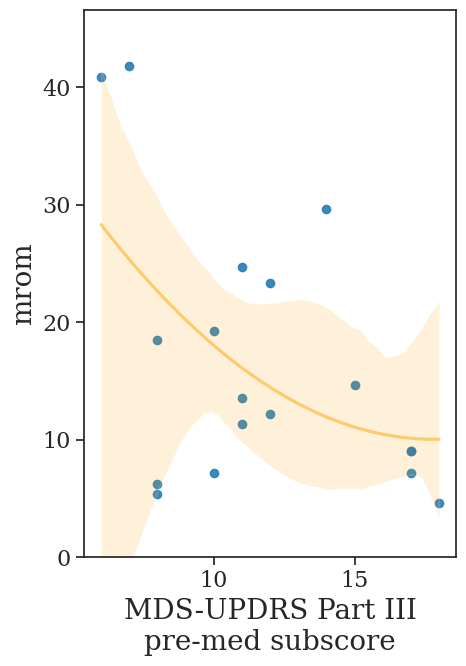

In [79]:
d_filtering_gait_performance_new = {}
for subject in gc.participant_ids.PD_IDS:
    with open(os.path.join(gc.paths.PATH_OUTPUT, 'classification_performance', 'arm_activity', f'{subject}.json'), 'r') as f:
        d_filtering_gait_performance_new[subject] = json.load(f)

for subject in gc.participant_ids.PD_IDS:
    d_quant[subject]['clinical'] = d_filtering_gait_performance_new[subject]['clinical']

df_filtered = df_quant.loc[df_quant['dataset']=='filtered'].copy()

for subject in gc.participant_ids.PD_IDS:
    for med_stage in ['pre', 'post']:
        for affected_side in ['MAS', 'LAS']:
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage} {affected_side}'), 'subscore'] = d_quant[subject]['clinical']['updrs'][med_stage][affected_side]['subscore']
            df_filtered.loc[(df_filtered[gc.columns.ID]==subject) & (df_filtered['population']==f'{med_stage} {affected_side}'), 'total_score'] = d_quant[subject]['clinical']['updrs'][med_stage][affected_side]['total']

measure = 'mrom'
correlation_metric = 'spearman'

df_med = df_filtered.loc[df_filtered['population']=='pre MAS']

fig, ax = plt.subplots(figsize=(5,7))

sns.scatterplot(data=df_med, x='subscore', y=measure, ax=ax, color=gc.plot_parameters.COLOR_PALETTE_FIRST_COLOR)
sns.regplot(x='subscore', y=measure, data=df_med, order=2,
            scatter_kws={'color': gc.plot_parameters.COLOR_PALETTE_SECOND_COLOR}, ci=95,
            line_kws={'color': 'orange', 'alpha': 0.5}, marker='o', label='PD patient', ax=ax)

if correlation_metric == 'pearson':
    rho = np.round(pearsonr(df_med[measure], df_med['subscore']).statistic,4)
    p_value = np.round(pearsonr(df_med[measure], df_med['subscore']).pvalue,4)
else:
    rho = np.round(spearmanr(df_med[measure], df_med['subscore']).correlation,4)
    p_value = np.round(spearmanr(df_med[measure], df_med['subscore']).pvalue,4)

zr = np.log((1+rho)/(1-rho))/2
lower = zr - 1.96/np.sqrt(len(df_med)-3)
upper = zr + 1.96/np.sqrt(len(df_med)-3)

ci = np.tanh(np.array([lower, upper]))

# print(np.round(rho,2), ci, p_value)

print(f"{measure}\nCorrelation: {rho} {ci}\nP-value: {p_value}")

# ax.set_title(f"{mp.arm_swing_parameter_map[measure]}\nCorrelation: {rho}\nP-value: {p_value}")

ax.set_ylabel(measure)
# ax.set_xlabel(d_clinical_rename['OFF_UPDRS_3_hypokinesia'])
ax.set_xlabel('MDS-UPDRS Part III\npre-med subscore')

ax.set_ylim([0, 1.05*ax.get_ylim()[1]])

fig.tight_layout()

plt.show()

#### Added value of filtering gait

P-value: 0.03423309326171875


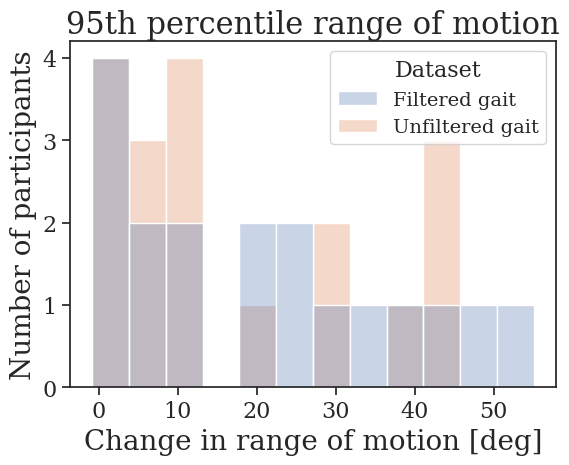

In [90]:
measure = 'prom'
segment_duration = 'overall'
dataset_1 = 'unfiltered'
dataset_2 = 'filtered'
affected_side = gc.descriptives.MOST_AFFECTED_SIDE

l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant_agg[x][affected_side][gc.descriptives.POST_MED][dataset_1].keys() and 
               segment_duration in d_quant_agg[x][affected_side][gc.descriptives.PRE_MED][dataset_1].keys() and
               segment_duration in d_quant_agg[x][affected_side][gc.descriptives.PRE_MED][dataset_2].keys() and
               segment_duration in d_quant_agg[x][affected_side][gc.descriptives.POST_MED][dataset_2].keys()] 

l_vals_filtered = [d_quant_agg[x][affected_side][gc.descriptives.POST_MED][dataset_2][segment_duration][measure] - d_quant_agg[x][affected_side][gc.descriptives.PRE_MED][dataset_2][segment_duration][measure] for x in l_valid_ids]
l_vals_unfiltered = [d_quant_agg[x][affected_side][gc.descriptives.POST_MED][dataset_1][segment_duration][measure] - d_quant_agg[x][affected_side][gc.descriptives.PRE_MED][dataset_1][segment_duration][measure] for x in l_valid_ids]

fig, ax = plt.subplots(figsize=(6,5))

df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

df_filtered_gait['Dataset'] = 'Filtered gait'
df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)
df_all['id'] = l_valid_ids * 2

print(f"P-value: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False)

ax.set_xlabel(f'Change in range of motion [deg]')
ax.set_ylabel('Number of participants')
ax.set_title('95th percentile range of motion')
ax.yaxis.get_major_locator().set_params(integer=True)
ax.legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

In [21]:
measure = '95p_rom'

for dataset in [dataset_1, dataset_2]:
    print(dataset)
    print("MEAN")
    l_mean = [d_quant[x]['effect_size'][measure][dataset]['overall']['mu_post'] - d_quant[x]['effect_size'][measure][dataset]['overall']['mu_pre'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_mean),2)} ({np.round(np.std(l_mean),2)})")

    print("STD")
    l_std = [d_quant[x]['effect_size'][measure][dataset]['overall']['std'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_std),2)} ({np.round(np.std(l_std),2)})")

    print("SRM")
    l_srm = [d_quant[x]['effect_size'][measure][dataset]['overall']['effect_size'] for x in l_valid_pd_ids]
    print(f"{np.round(np.mean(l_srm),2)} ({np.round(np.std(l_srm),2)})\n")

pred_gait_predicted_noaa
MEAN
19.91 (15.7)
STD
1.92 (1.32)
SRM
13.94 (14.88)

predicted_gait
MEAN
17.1 (14.87)
STD
1.46 (0.76)
SRM
14.56 (14.91)



In [64]:
measure = '95p_rom'
df_time_std = pd.DataFrame()

for subject in gc.participant_ids.L_PD_IDS:
    mins_gait = np.round((d_quant[subject]['unfiltered_gait']['pre']['MAS']['seconds']['overall'] + d_quant[subject]['unfiltered_gait']['post']['MAS']['seconds']['overall']) / 60, 1)
    std_gait = np.round(d_quant[subject]['effect_size'][measure]['predicted_gait']['overall']['std'], 2)
    mins_arm_swing = np.round((d_quant[subject]['filtered_gait']['pre']['MAS']['seconds']['overall'] + d_quant[subject]['filtered_gait']['post']['MAS']['seconds']['overall']) / 60, 1)
    std_arm_swing = np.round(d_quant[subject]['effect_size'][measure]['pred_gait_predicted_noaa']['overall']['std'], 2)

    perc_increase_time = (mins_arm_swing-mins_gait)/mins_gait*100
    perc_increase_std = (std_arm_swing-std_gait)/std_gait*100

    df_time_std = pd.concat([df_time_std, pd.DataFrame([mins_gait, std_gait, mins_arm_swing, std_arm_swing, perc_increase_time, perc_increase_std], index=['mins_gait', 'std_gait', 'mins_arm_swing', 'std_arm_swing', '%_change_time', '%_change_std'], columns=[subject]).T])

df_time_std

,mins_gait,std_gait,mins_arm_swing,std_arm_swing,%_change_time,%_change_std
hbv002,31.2,0.80,22.1,0.81,-29.166667,1.250000
hbv012,28.1,3.37,7.4,2.57,-73.665480,-23.738872
hbv014,37.6,0.90,19.7,1.02,-47.606383,13.333333
hbv015,32.3,2.57,6.8,4.59,-78.947368,78.599222
hbv016,17.8,1.33,6.5,0.50,-63.483146,-62.406015
hbv017,28.2,0.84,2.3,1.86,-91.843972,121.428571
hbv022,37.9,1.10,26.7,0.85,-29.551451,-22.727273
hbv024,34.5,0.86,14.1,0.78,-59.130435,-9.302326
hbv039,48.1,0.24,2.9,2.18,-93.970894,808.333333
hbv043,24.0,0.86,12.1,1.23,-49.583333,43.023256


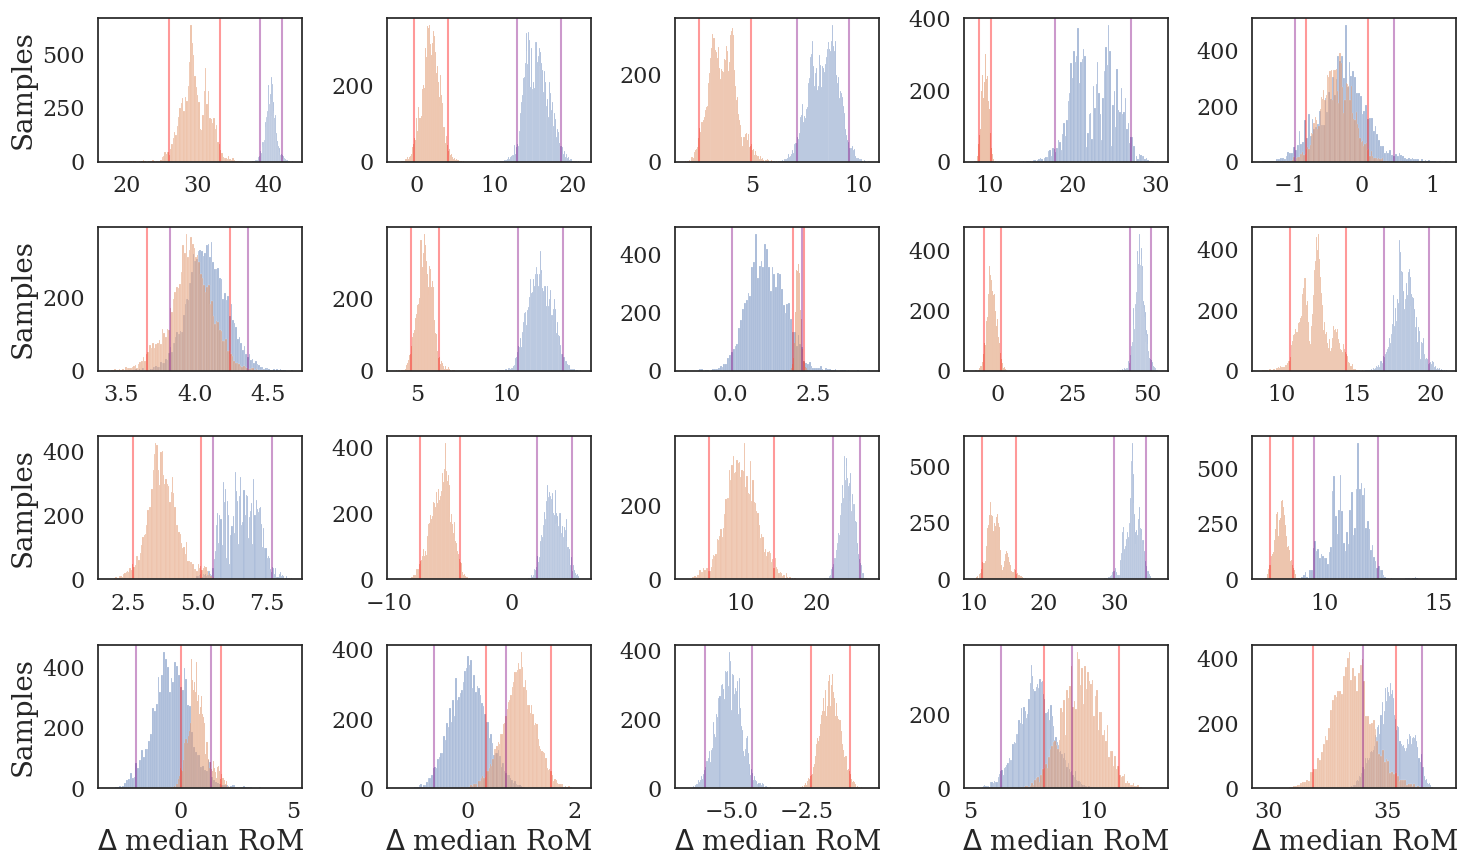

In [24]:
ncols = 5
parameter = 'median_rom'

fig, ax = plt.subplots(nrows=len(l_valid_pd_ids)//ncols, ncols=ncols, figsize=(15, 9))

for j, subject in enumerate(l_valid_pd_ids):
    df_es = pd.read_pickle(os.path.join(gc.paths.PATH_OUTPUT, 'quantification', f'{subject}.pkl'))
    df_es.loc[df_es['dataset']=='predicted_gait', 'dataset'] = 'Unfiltered gait'
    df_es.loc[df_es['dataset']=='pred_gait_predicted_noaa', 'dataset'] = 'Filtered gait'

    for dataset in ['Filtered gait', 'Unfiltered gait']:
        sns.histplot(data=df_es.loc[df_es['dataset']==dataset, f'diff_{parameter}'].values[0], bins=100, ax=ax[j//ncols, j%ncols], alpha=0.5, kde=False)

    # ax[j//ncols, j%ncols].legend(title='Dataset', loc='upper left')

    for qnt in [0.025, 0.975]:
        ax[j//ncols, j%ncols].axvline(x=np.quantile(sorted(df_es.loc[df_es['dataset']=='Filtered gait', f'diff_{parameter}'].values), qnt), alpha=0.4, color='purple')
        ax[j//ncols, j%ncols].axvline(x=np.quantile(sorted(df_es.loc[df_es['dataset']=='Unfiltered gait', f'diff_{parameter}'].values), qnt), alpha=0.4, color='red')

    # ax[j//ncols, j%ncols].set_title(subject)
    # if l_valid_pd_ids.index(subject) % nrows == 0:
    #     ax[j//ncols, j%ncols].set_ylabel('Samples')
    # else:
    #     ax[j//ncols, j%ncols].set_ylabel('')

    if j//ncols == 3:
        ax[j//ncols, j%ncols].set_xlabel(r'$\Delta$ median RoM')  
    else:
        ax[j//ncols, j%ncols].set_xlabel('')
    
    if j%ncols == 0:
        ax[j//ncols, j%ncols].set_ylabel('Samples')
    else:
        ax[j//ncols, j%ncols].set_ylabel('')

fig.tight_layout()

plt.show()    

### Exploration effect size
1. How does the ROM change after medication intake, for filtered and unfiltered gait, based on video annotations?
    - Effect size filtered vs unfiltered gait
    - Absolute change in arm swing parameters 
    - Change in ROM distribution

2. And based on the filter?

#### 1a - Effect size filtered vs unfiltered gait


Measure: median_rom
P-value overall segments: 0.026641845703125
P-value short segments: 0.4130859375
P-value moderately_long segments: 0.3954620361328125
P-value long segments: 0.02684783935546875
P-value very_long segments: 0.18186569213867188

Measure: 95p_rom
P-value overall segments: 0.5458755493164062
P-value short segments: 0.7646484375
P-value moderately_long segments: 0.4413337707519531
P-value long segments: 0.550872802734375
P-value very_long segments: 0.9843215942382812


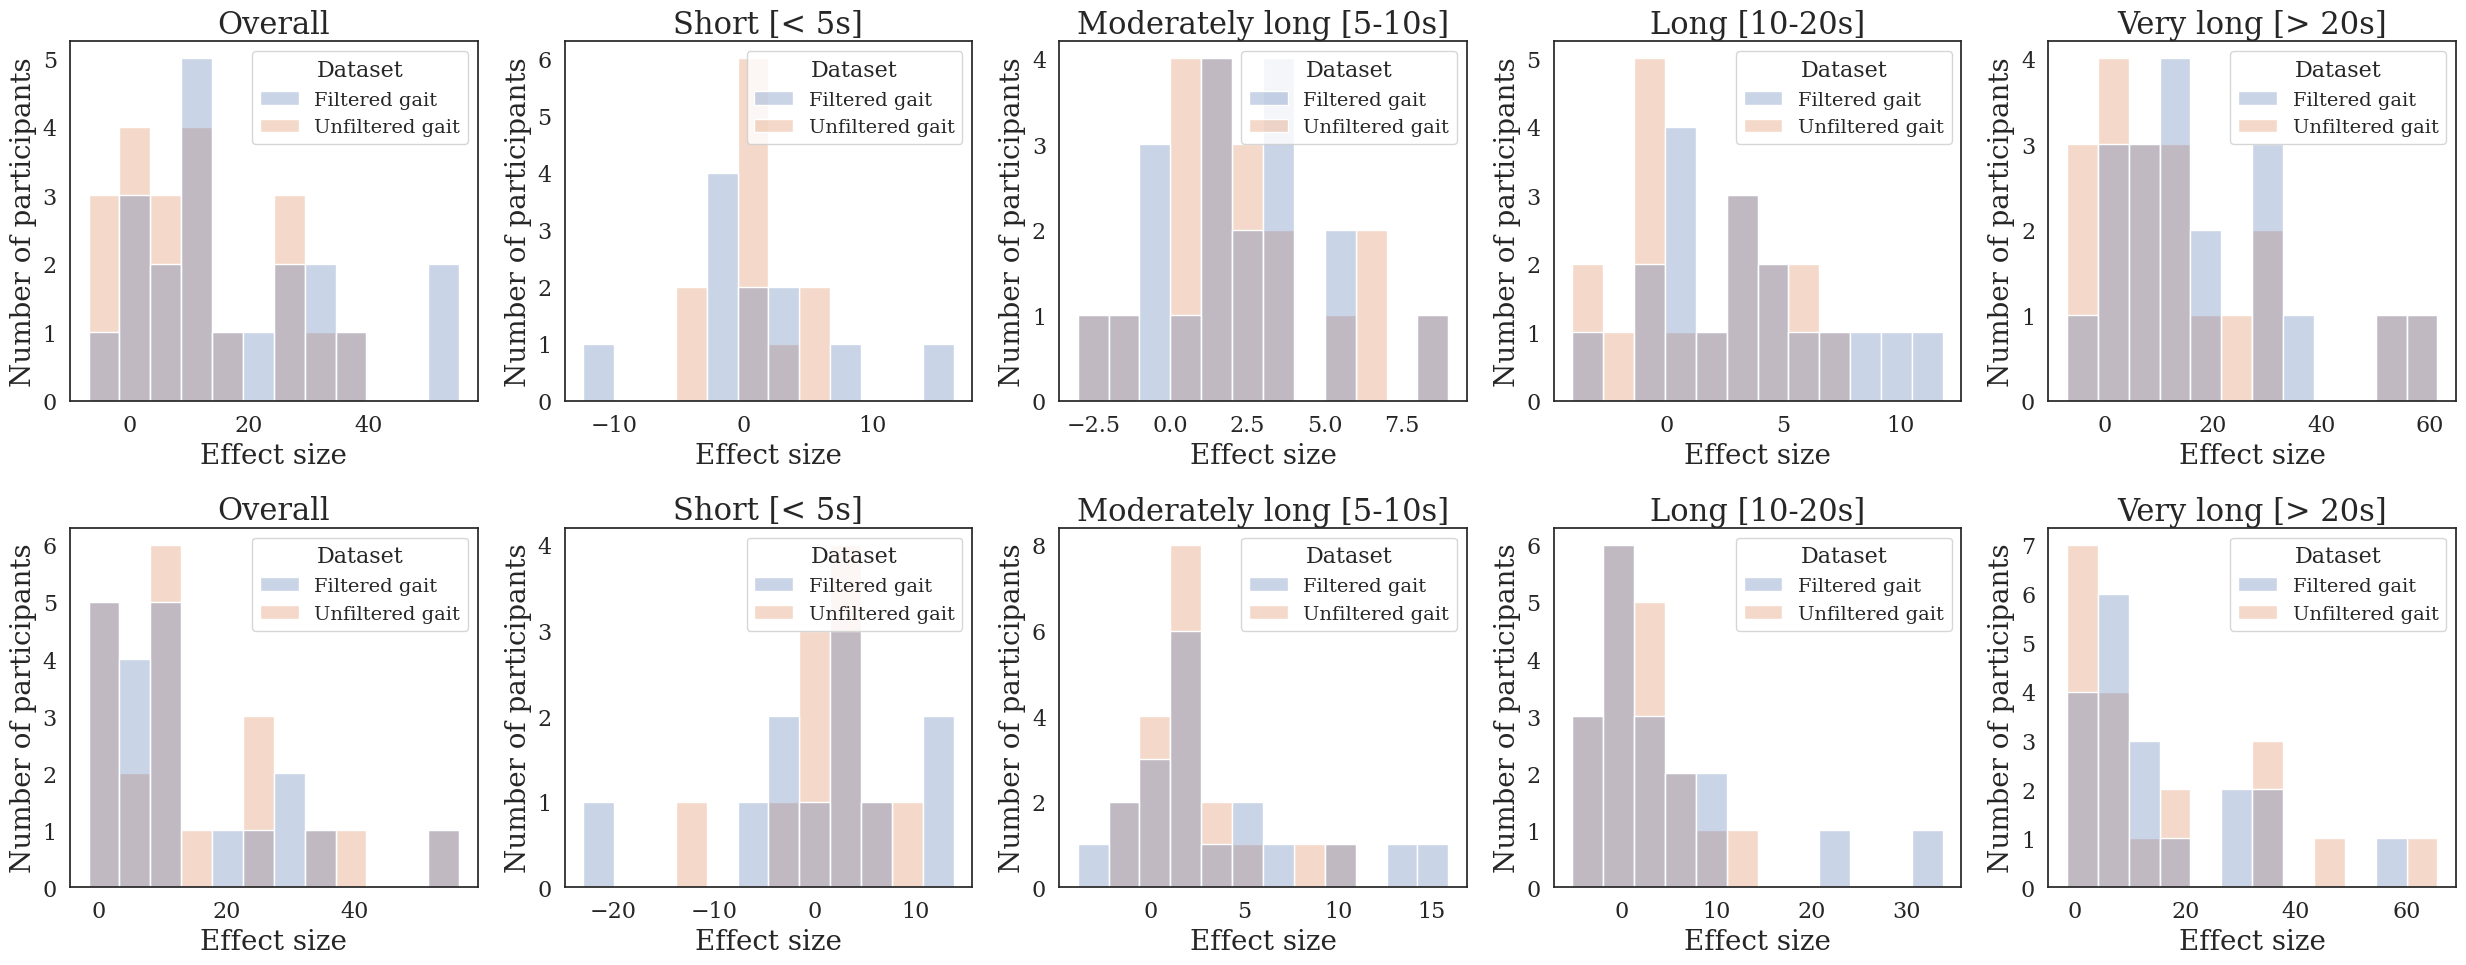

In [25]:
dataset_1 = 'pred_gait_annotated_noaa'
dataset_2 = 'predicted_gait'

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))

for i, measure in enumerate(['median_rom', '95p_rom']):
    print(f"\nMeasure: {measure}")
    for j, segment_duration in enumerate(['overall', 'short', 'moderately_long', 'long', 'very_long']):
        l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and segment_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 

        l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['effect_size'] for x in l_valid_ids]
        l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['effect_size'] for x in l_valid_ids]

        df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
        df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

        df_filtered_gait['Dataset'] = 'Filtered gait'
        df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

        df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)

        print(f"P-value {segment_duration} segments: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

        g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False, ax=ax[i,j])

        if segment_duration != 'overall': 
            ax[i,j].set_title(f"{mp.segment_rename[segment_duration]}")
        else:
            ax[i,j].set_title(f"Overall")
        ax[i,j].set_xlabel('Effect size')
        ax[i,j].set_ylabel('Number of participants')
        ax[i,j].yaxis.get_major_locator().set_params(integer=True)
        ax[i,j].legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

#### 1b - Absolute change in arm swing parameters

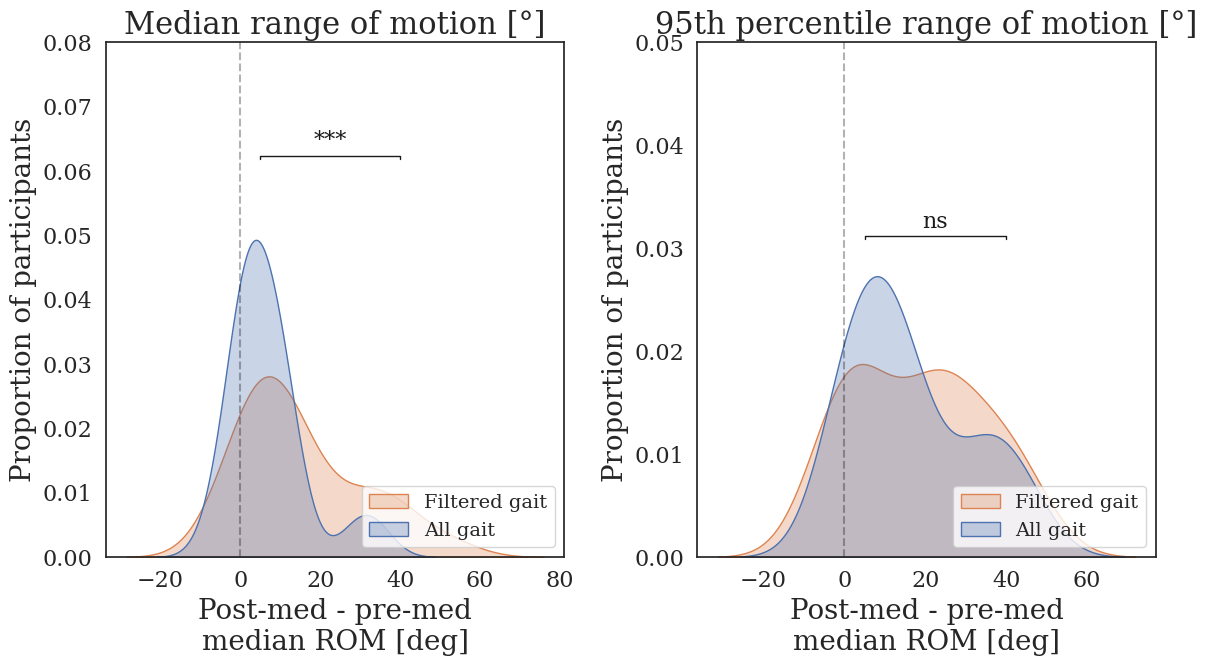

In [41]:
df_abs_change = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['unfiltered_gait', 'true_no_other_arm_activity']:
        for affected_side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
            for measure in ['range_of_motion_median', 'range_of_motion_quantile_95']:
                if measure in d_quant[subject][dataset]['pre'][affected_side]['values'].keys():
                    abs_change = d_quant[subject][dataset]['post'][affected_side]['values'][measure]['overall'] - d_quant[subject][dataset]['pre'][affected_side]['values'][measure]['overall']
                    df_abs_change = pd.concat([df_abs_change, pd.DataFrame([subject, dataset, affected_side, measure, abs_change], index=['id', 'dataset', 'side', 'measure', 'abs_change']).T])

fig, ax = plt.subplots(ncols=2, figsize=(12,7))

for j, measure in enumerate(['range_of_motion_median', 'range_of_motion_quantile_95']):

    df_measure = df_abs_change.loc[(df_abs_change['measure']==measure) & (df_abs_change['side']=='MAS')]

    sns.kdeplot(data=df_measure, x='abs_change', hue='dataset', alpha=0.3, fill=True, common_norm=False, ax=ax[j])

    # ax.set_xlim([df_abs_change[f'{metric}_diff'].min(), df_abs_change[f'{metric}_diff'].max()])

    p_value = calculate_pvalue(x=list(df_measure.loc[df_measure['dataset']=='unfiltered_gait', 'abs_change'].values), 
                               y=list(df_measure.loc[df_measure['dataset']=='true_no_other_arm_activity', 'abs_change'].values),
                               test='wilcoxon')[1]

    x_min = 5
    x_max = 40
    if j == 0:
        y_min_significance = 0.06
        y_max = 0.08
    else:
        y_min_significance = 0.03
        y_max = 0.05

    plot_significance(ax=ax[j], x_min=x_min, x_max=x_max, pvalue=p_value, y_min_significance=y_min_significance, gap=0, row=1, text_size=16)
    ax[j].set_ylim([0, y_max])
    ax[j].axvline(0, color='black', linestyle='--', alpha=0.3)

    # xlabel =  'Post-med - pre-med\n' + r'$95^{th}$ perc ROM [deg]'
    xlabel = 'Post-med - pre-med\nmedian ROM [deg]'

    ax[j].set_title(mp.arm_swing_parameter_map[measure])
    ax[j].legend(['Filtered gait', 'All gait'], loc='lower right')
    ax[j].set_xlabel(xlabel)
    ax[j].set_ylabel('Proportion of participants')
# plt.ylim([0, 0.18])
# plt.title("Difference in median range of motion between PD OFF and PD ON")

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_diff_density_med.png'))

plt.show()

In [27]:
# Standard deviation
df_std = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['predicted_gait', 'pred_gait_annotated_noaa', 'pred_gait_predicted_noaa']:
        for measure in ['median_rom', '95p_rom']:
            for stat in ['mu_pre', 'mu_post', 'std', 'effect_size']:
                df_std = pd.concat([df_std, pd.DataFrame([subject, dataset, measure, stat, d_quant[subject]['effect_size'][measure][dataset]['overall'][stat]], index=['id', 'dataset', 'measure', 'stat', 'value']).T])
            
df_std.pivot_table(index='dataset', columns=['measure', 'stat'], values='value').reindex(['median_rom', '95p_rom'], axis=1, level=0).sort_index(level=0, ascending=False)

measure                   median_rom                                  \
stat                     effect_size    mu_post     mu_pre       std   
dataset                                                                
predicted_gait             11.194371  20.388634  13.564605  0.729861   
pred_gait_predicted_noaa   15.168002  29.627981  16.092715  0.987817   
pred_gait_annotated_noaa   17.577443  31.080913  15.853796  1.038464   

measure                      95p_rom                                  
stat                     effect_size    mu_post     mu_pre       std  
dataset                                                               
predicted_gait              13.77081  45.629559  29.358658  1.534175  
pred_gait_predicted_noaa   12.806175  47.651235   29.27275   2.46026  
pred_gait_annotated_noaa   12.511019  47.762885  29.577775  2.397975

#### 1c - Change in ROM distribution

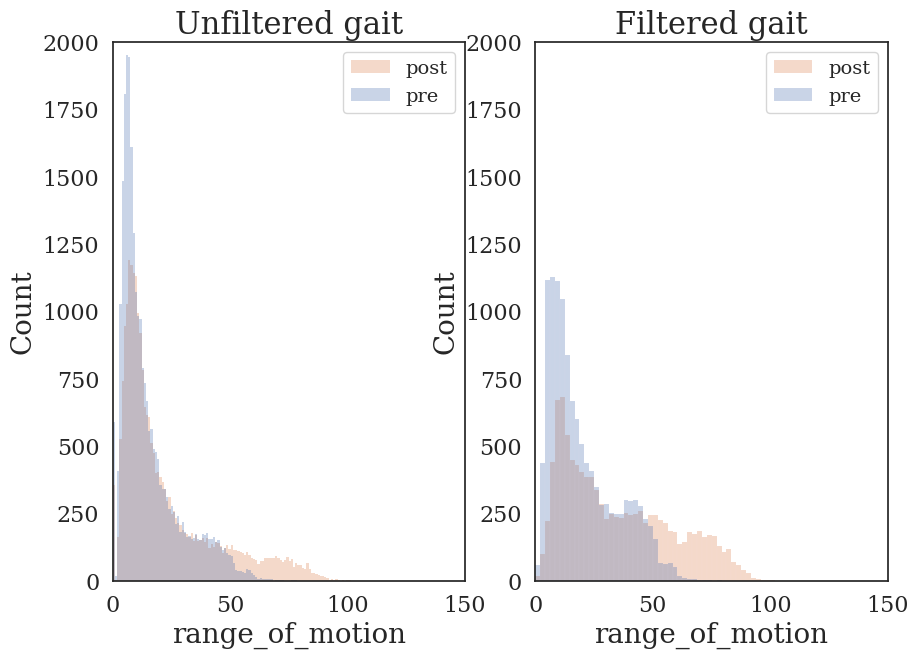

In [28]:
l_dfs = []
for subject in gc.participant_ids.L_PD_IDS:
    l_dfs.append(pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS.pkl')))

df_features = pd.concat(l_dfs, ignore_index=True)

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

sns.histplot(data=df_features, x='range_of_motion', hue='pre_or_post', alpha=0.3, color='blue', label='gait', ax=ax[0])
sns.histplot(data=df_features.loc[(df_features['no_other_arm_activity_majority_voting']==1)], x='range_of_motion', hue='pre_or_post', alpha=0.3, color='green', label='gait NOAA', ax=ax[1])

ax[0].set_title('Unfiltered gait')
ax[1].set_title('Filtered gait')

for j in range(2):
    ax[j].set_xlim([0,150])
    ax[j].set_ylim([0, 2000])
    ax[j].legend(['post', 'pre'])

plt.show()

In [29]:
df_features['range_of_motion'].agg(['median', 'mean', 'std'])

median    12.250773
mean      19.037797
std       19.023848
Name: range_of_motion, dtype: float64

In [30]:
df_features.loc[(df_features['no_other_arm_activity_majority_voting']==1), 'range_of_motion'].agg(['median', 'mean', 'std'])

median    20.697746
mean      27.430601
std       23.347205
Name: range_of_motion, dtype: float64

#### 2a - Effect size filtered vs unfiltered gait


Measure: median_rom
P-value overall segments: 0.15364646911621094
P-value short segments: nan
P-value moderately_long segments: 0.3954620361328125
P-value long segments: 0.28372955322265625
P-value very_long segments: 0.8595733642578125

Measure: 95p_rom
P-value overall segments: 1.0
P-value short segments: nan
P-value moderately_long segments: 0.12318801879882812
P-value long segments: 0.39273834228515625
P-value very_long segments: 0.8287849426269531


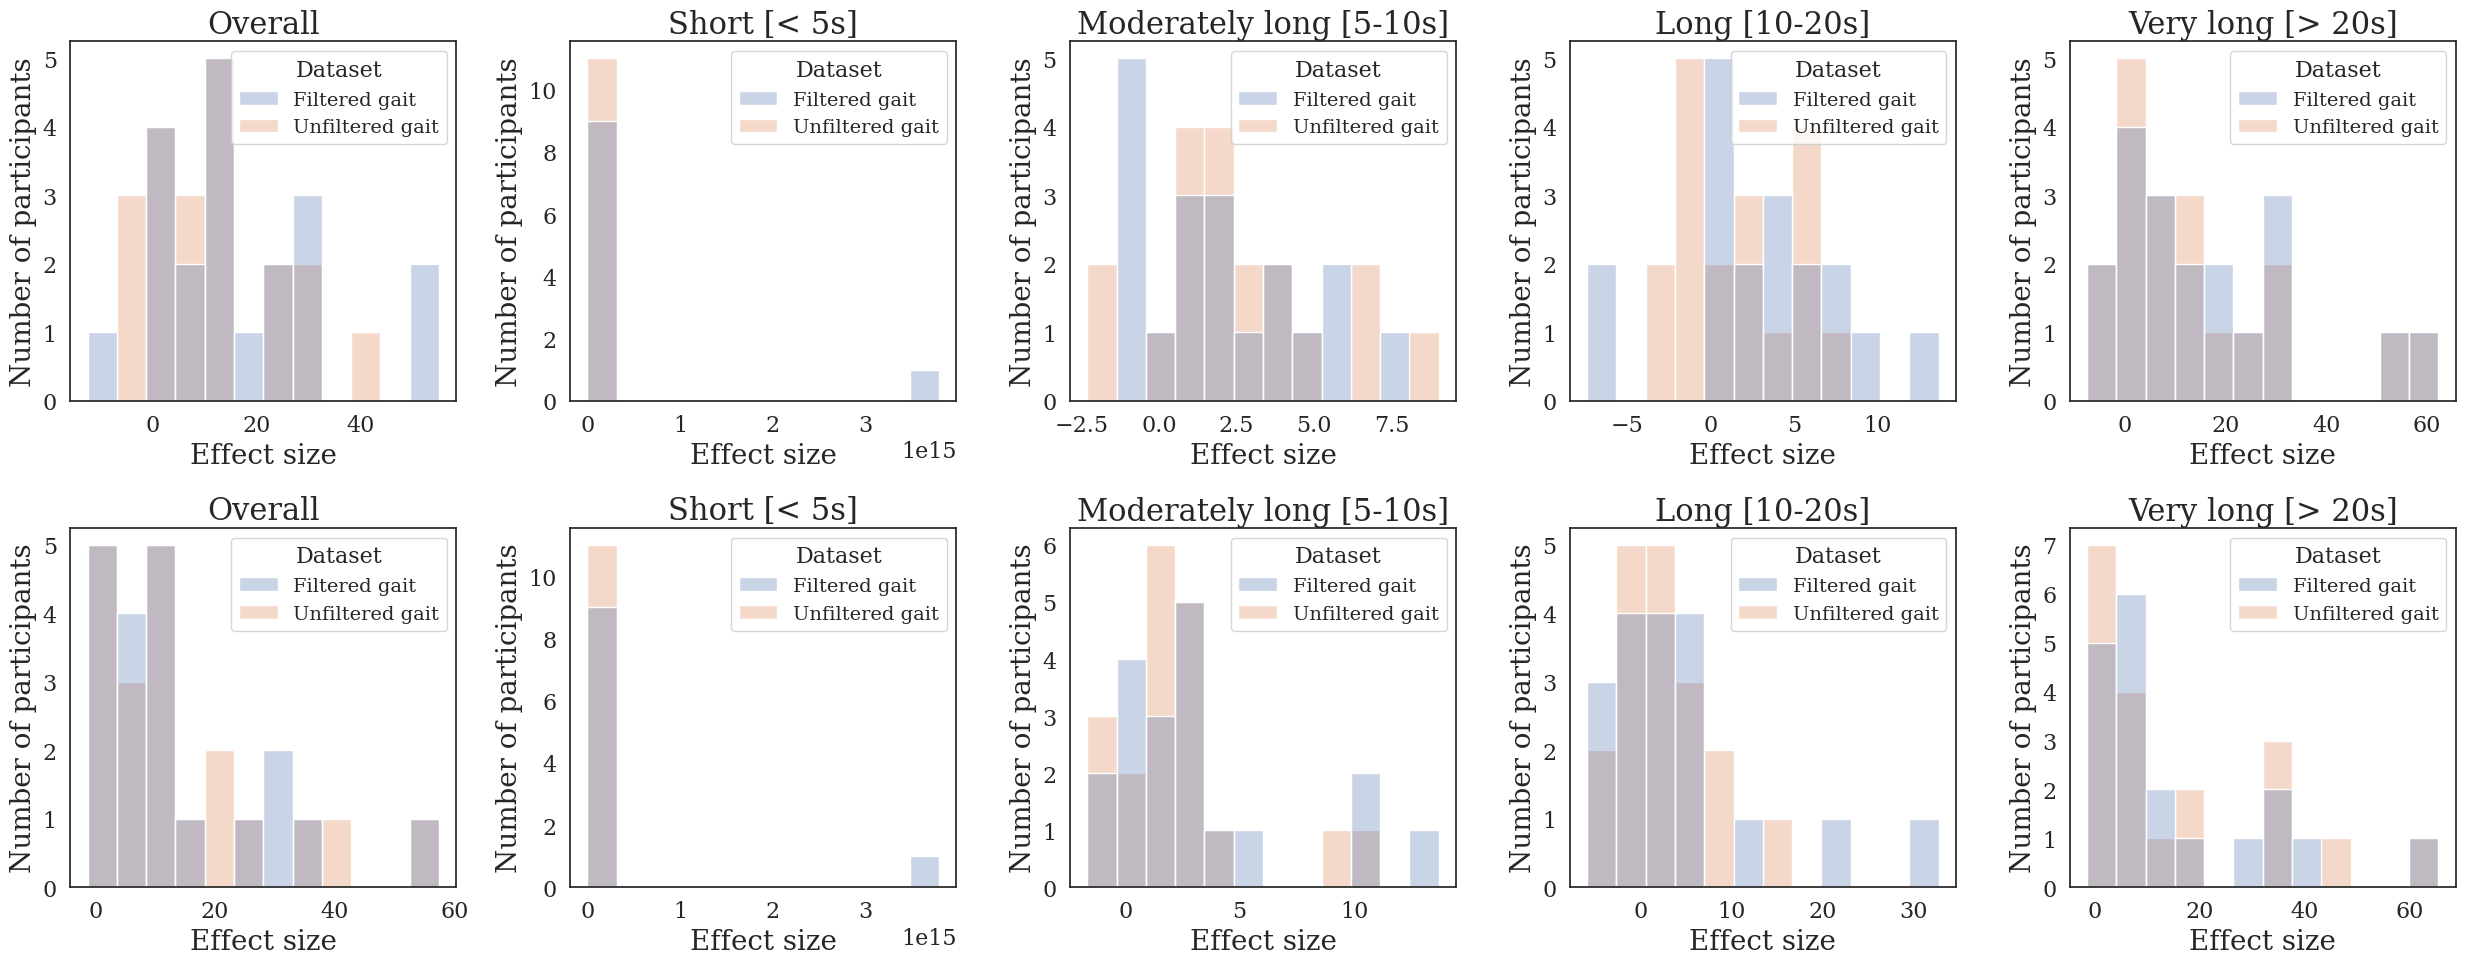

In [31]:
measure = '95p_rom'
segment_duration = 'overall'

dataset_1 = 'pred_gait_predicted_noaa'
dataset_2 = 'predicted_gait'

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25,10))

for i, measure in enumerate(['median_rom', '95p_rom']):
    print(f"\nMeasure: {measure}")
    for j, segment_duration in enumerate(['overall', 'short', 'moderately_long', 'long', 'very_long']):
        l_valid_ids = [x for x in l_valid_pd_ids if segment_duration in d_quant[x]['effect_size'][measure][dataset_1].keys() and segment_duration in d_quant[x]['effect_size'][measure][dataset_2].keys()] 

        l_vals_filtered = [d_quant[x]['effect_size'][measure][dataset_1][segment_duration]['effect_size'] for x in l_valid_ids]
        l_vals_unfiltered = [d_quant[x]['effect_size'][measure][dataset_2][segment_duration]['effect_size'] for x in l_valid_ids]

        df_filtered_gait = pd.DataFrame(l_vals_filtered, columns=['effect_size'])
        df_unfiltered_gait = pd.DataFrame(l_vals_unfiltered, columns=['effect_size'])

        df_filtered_gait['Dataset'] = 'Filtered gait'
        df_unfiltered_gait['Dataset'] = 'Unfiltered gait'

        df_all = pd.concat([df_filtered_gait, df_unfiltered_gait], ignore_index=True).reset_index(drop=True)

        print(f"P-value {segment_duration} segments: {wilcoxon(l_vals_filtered, l_vals_unfiltered, alternative='two-sided')[1]}")

        g = sns.histplot(data=df_all, x='effect_size', hue='Dataset', alpha=0.3, fill=True, bins=12, common_norm=False, legend=False, ax=ax[i,j])

        if segment_duration != 'overall': 
            ax[i,j].set_title(f"{mp.segment_rename[segment_duration]}")
        else:
            ax[i,j].set_title(f"Overall")
        ax[i,j].set_xlabel('Effect size')
        ax[i,j].set_ylabel('Number of participants')
        ax[i,j].yaxis.get_major_locator().set_params(integer=True)
        ax[i,j].legend(title='Dataset', labels=['Unfiltered gait', 'Filtered gait'], reverse=True, loc='upper right')

fig.tight_layout()

plt.show()

#### 2b - Absolute change in arm swing parameters

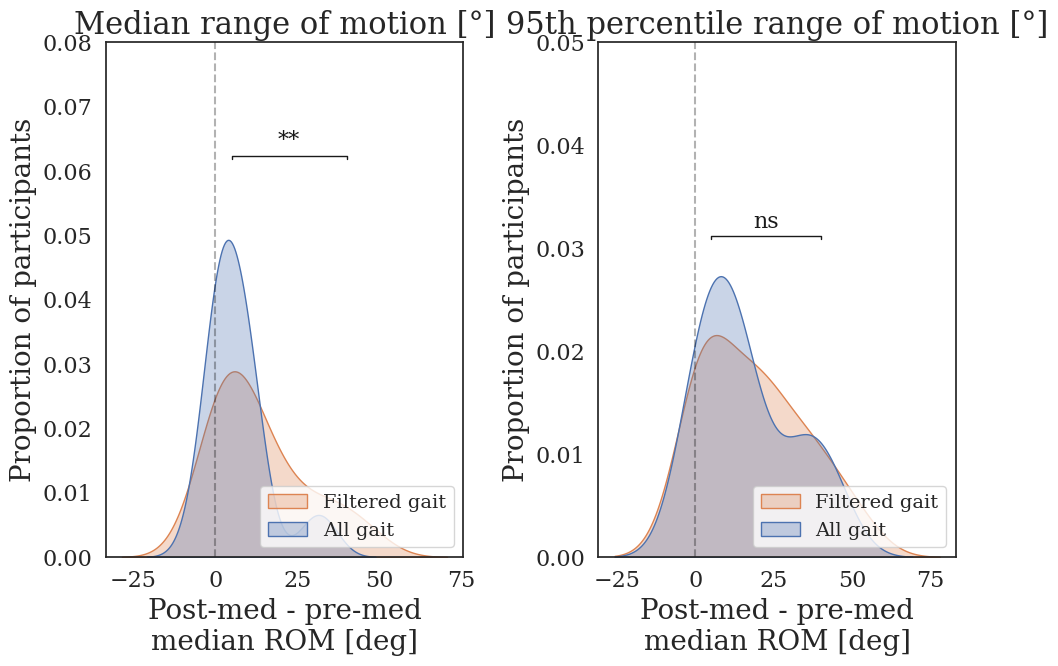

In [32]:
df_abs_change = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['unfiltered_gait', 'filtered_gait']:
        for affected_side in [gc.descriptives.MOST_AFFECTED_SIDE, gc.descriptives.LEAST_AFFECTED_SIDE]:
            for measure in ['range_of_motion_median', 'range_of_motion_quantile_95']:
                if measure in d_quant[subject][dataset]['pre'][affected_side]['values'].keys():
                    abs_change = d_quant[subject][dataset]['post'][affected_side]['values'][measure]['overall'] - d_quant[subject][dataset]['pre'][affected_side]['values'][measure]['overall']
                    df_abs_change = pd.concat([df_abs_change, pd.DataFrame([subject, dataset, affected_side, measure, abs_change], index=['id', 'dataset', 'side', 'measure', 'abs_change']).T])

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

for j, measure in enumerate(['range_of_motion_median', 'range_of_motion_quantile_95']):

    df_measure = df_abs_change.loc[(df_abs_change['measure']==measure) & (df_abs_change['side']=='MAS')]

    sns.kdeplot(data=df_measure, x='abs_change', hue='dataset', alpha=0.3, fill=True, common_norm=False, ax=ax[j])

    # ax.set_xlim([df_abs_change[f'{metric}_diff'].min(), df_abs_change[f'{metric}_diff'].max()])

    p_value = calculate_pvalue(x=list(df_measure.loc[df_measure['dataset']=='unfiltered_gait', 'abs_change'].values), 
                               y=list(df_measure.loc[df_measure['dataset']=='filtered_gait', 'abs_change'].values),
                               test='wilcoxon')[1]

    x_min = 5
    x_max = 40
    if j == 0:
        y_min_significance = 0.06
        y_max = 0.08
    else:
        y_min_significance = 0.03
        y_max = 0.05

    plot_significance(ax=ax[j], x_min=x_min, x_max=x_max, pvalue=p_value, y_min_significance=y_min_significance, gap=0, row=1, text_size=16)
    ax[j].set_ylim([0, y_max])
    ax[j].axvline(0, color='black', linestyle='--', alpha=0.3)

    # xlabel =  'Post-med - pre-med\n' + r'$95^{th}$ perc ROM [deg]'
    xlabel = 'Post-med - pre-med\nmedian ROM [deg]'

    ax[j].set_title(mp.arm_swing_parameter_map[measure])
    ax[j].legend(['Filtered gait', 'All gait'], loc='lower right')
    ax[j].set_xlabel(xlabel)
    ax[j].set_ylabel('Proportion of participants')
# plt.ylim([0, 0.18])
# plt.title("Difference in median range of motion between PD OFF and PD ON")

fig.tight_layout()

# plt.savefig(os.path.join(path_figures, 'asq', f'{metric}_diff_density_med.png'))

plt.show()

In [33]:
# Standard deviation
df_std = pd.DataFrame()
for subject in gc.participant_ids.L_PD_IDS:
    for dataset in ['predicted_gait', 'pred_gait_annotated_noaa', 'pred_gait_predicted_noaa']:
        for measure in ['median_rom', '95p_rom']:
            for stat in ['mu_pre', 'mu_post', 'std', 'effect_size']:
                df_std = pd.concat([df_std, pd.DataFrame([subject, dataset, measure, stat, d_quant[subject]['effect_size'][measure][dataset]['overall'][stat]], index=['id', 'dataset', 'measure', 'stat', 'value']).T])
            
df_std.pivot_table(index='dataset', columns=['measure', 'stat'], values='value').reindex(['median_rom', '95p_rom'], axis=1, level=0).sort_index(ascending=False)

measure                   median_rom                                  \
stat                     effect_size    mu_post     mu_pre       std   
dataset                                                                
predicted_gait             11.194371  20.388634  13.564605  0.729861   
pred_gait_predicted_noaa   15.168002  29.627981  16.092715  0.987817   
pred_gait_annotated_noaa   17.577443  31.080913  15.853796  1.038464   

measure                      95p_rom                                  
stat                     effect_size    mu_post     mu_pre       std  
dataset                                                               
predicted_gait              13.77081  45.629559  29.358658  1.534175  
pred_gait_predicted_noaa   12.806175  47.651235   29.27275   2.46026  
pred_gait_annotated_noaa   12.511019  47.762885  29.577775  2.397975

#### 2c - Change in ROM distribution

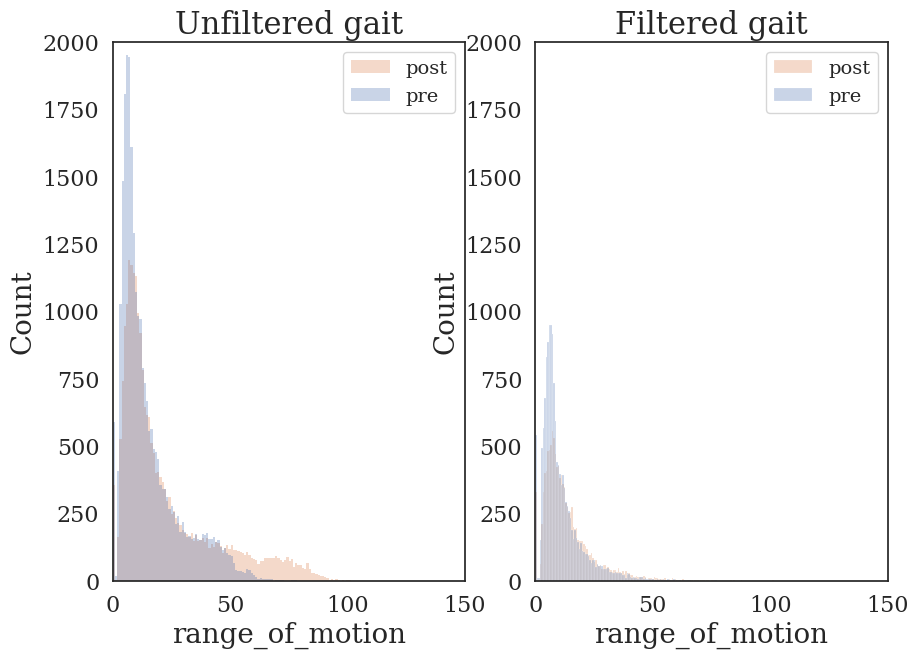

In [34]:
l_dfs = []
for subject in gc.participant_ids.L_PD_IDS:
    df_features = pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_FEATURES, f'{subject}_MAS.pkl'))
    df_features[gc.columns.ID] = subject
    df_predictions = pd.read_pickle(os.path.join(gc.paths.PATH_ARM_ACTIVITY_PREDICTIONS, gc.classifiers.ARM_ACTIVITY_CLASSIFIER_SELECTED, f'{subject}_df.pkl'))
    df_predictions = df_predictions.loc[df_predictions['side']=='MAS', ['window_nr', gc.columns.PRED_NO_OTHER_ARM_ACTIVITY_PROBA]]

    l_dfs.append(pd.merge(df_features, df_predictions, on='window_nr', how='inner'))

df_features = pd.concat(l_dfs, ignore_index=True)

fig, ax = plt.subplots(ncols=2, figsize=(10,7))

sns.histplot(data=df_features, x='range_of_motion', hue='pre_or_post', alpha=0.3, color='blue', ax=ax[0])
sns.histplot(data=df_features.loc[(df_features[gc.columns.PRED_NO_OTHER_ARM_ACTIVITY_PROBA]<0.5)], x='range_of_motion', hue='pre_or_post', alpha=0.3, color='green', ax=ax[1])

ax[0].set_title('Unfiltered gait')
ax[1].set_title('Filtered gait')

for j in range(2):
    ax[j].set_xlim([0,150])
    ax[j].legend(['post', 'pre'])
    ax[j].set_ylim([0, 2000])

plt.show()